<h1 align="center">Ownership structure and company’s performance: evidence from Russia’s publicly listed companies</h1> 

## <center>Objectives</center>
The primary objective of this thesis is to investigate the relationship between ownership structure and firm performance in Russian publicly listed companies during the period from 2014 to 2018. The study focuses on assessing how both managerial and state shareholdings influence the performance of these firms. To achieve this, the analysis begins with an examination of individual firm-level data. Subsequently, a portfolio-based approach is employed to evaluate the impact of state ownership on the stock performance of these firms (refer to the notebook titled 'Portfolio Performance T-test'). The evaluation of firm performance is based on average values of market-to-book equity ratio (M/B) and return on assets (ROA) for the years 2015 to 2018. The ownership structure of the companies is measured using data from the year 2014. The complete text of this thesis is available for reference in [Electronic Theses & Dissertations Center](http://rave.ohiolink.edu/etdc/view?acc_num=ysu158920696033375).

In [131]:
# install libraries
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.stats.diagnostic import het_white
from linearmodels.iv import IV2SLS

# Install necessary packages (if not already installed)
# !pip install linearmodels

In [132]:
# Read data from an Excel file with error handling
try:
    df = pd.read_excel(
        r'C:\Users\daure\Desktop\Google Data Analytics\Capstone\OLS and 2SLS_MB regression_Python.xlsx',
        sheet_name="Main", header=0, index_col=0
    )
except Exception as e:
    print(f"Error reading Excel file: {str(e)}")

In [133]:
# Display DataFrame with rounded values
print(df.round(2))

                         Industry  SHM  SHST  SqSHM  SqSHST    MB  CXP_Assets  \
#                                                                               
1                       Financial  0.0  0.00   0.00    0.00  0.86        0.00   
2               Metals and Mining  0.0  0.69   0.00    0.47  2.62        0.09   
3                       Financial  0.0  0.61   0.00    0.37  0.52        0.00   
4                        Consumer  0.0  0.00   0.00    0.00  3.57        0.08   
5                       Financial  0.3  0.00   0.09    0.00  2.53        0.00   
..                            ...  ...   ...    ...     ...   ...         ...   
202                     Financial  0.0  0.00   0.00    0.00  0.53        0.00   
203                   Industrials  0.0  0.27   0.00    0.07 -0.53        0.12   
204             Metals and Mining  0.0  0.00   0.00    0.00  1.39        0.10   
205                   Industrials  0.0  0.00   0.00    0.00  0.68        0.04   
206  Chemicals and Pertochem

In [134]:
# Display column names of the DataFrame
print(df.columns.tolist())

['Industry', 'SHM', 'SHST', 'SqSHM', 'SqSHST', 'MB', 'CXP_Assets', 'LTD_Assets', 'Dummy_overvalued', 'Dummy_undervalued', 'DummyBANKS', 'DummyElecUt', 'overvalSHM', 'overvalSHST']


In [135]:
# Descriptive statistics (excluding dummy variables)
desc_columns = ['SHM', 'SHST', 'SqSHM', 'SqSHST', 'MB', 'CXP_Assets', 'LTD_Assets', 'overvalSHM', 'overvalSHST']
desc_stats = df[desc_columns].describe().round(2)
print(desc_stats)

          SHM    SHST   SqSHM  SqSHST      MB  CXP_Assets  LTD_Assets  \
count  206.00  206.00  206.00  206.00  206.00      206.00      206.00   
mean     0.09    0.26    0.05    0.19    1.42        0.05        0.18   
std      0.21    0.35    0.15    0.30    3.01        0.06        0.28   
min      0.00    0.00    0.00    0.00  -10.86        0.00        0.00   
25%      0.00    0.00    0.00    0.00    0.36        0.00        0.00   
50%      0.00    0.00    0.00    0.00    0.85        0.04        0.12   
75%      0.00    0.52    0.00    0.27    1.86        0.09        0.27   
max      0.96    1.00    0.93    1.00   21.20        0.25        3.16   

       overvalSHM  overvalSHST  
count      206.00       206.00  
mean         0.05         0.11  
std          0.15         0.26  
min          0.00         0.00  
25%          0.00         0.00  
50%          0.00         0.00  
75%          0.00         0.00  
max          0.81         0.99  


### Description of the variables
|<center>Abbreviation for variable<center>|<center>Explanation<center>|
|---|---|
|<center>MB</center> |<center>The ratio of equity market value over book value</center>|
|<center>overval|1, if M/B>1 or M/B < 0, 0 otherwise<center>|
|<center>SHM<center>|<center>Share owned by executive managers<center>|
|<center>SHST<center>|<center>Share owned by the state<center>|
|<center>SqSHM<center>|<center>Squared value of share owned by executive managers<center>|
|<center>SqSHST<center>|<center>Squared value of share owned by the state<center>|
|<center>DummyBANKS<center>|<center>1, if a firm is a commercial bank, 0 otherwise<center>|
|<center>DummyElecUt<center>|<center>1, if a firm is an electric utility, 0 otherwise<center>|
|<center>overvalSHM<center>|<center>Share owned by managers in overvalued companies<center>|
|<center>overvalSHST<center>|<center>Share owned by the state in overvalued companies<center>|
|<center>ROA<center>|<center>Return on assets<center>|
|<center>CXP<center>|<center>Capital expenditures over assets<center>|
|<center>LTD<center>|<center>Long-term debt over assets<center>|

In [136]:
# Correlation matrix of variables used in the regression of M/B
corr_matrix = df.corr().round(2)
print(corr_matrix)

                    SHM  SHST  SqSHM  SqSHST    MB  CXP_Assets  LTD_Assets  \
SHM                1.00 -0.31   0.95   -0.27  0.03       -0.04        0.05   
SHST              -0.31  1.00  -0.25    0.97 -0.14        0.27       -0.00   
SqSHM              0.95 -0.25   1.00   -0.22  0.00       -0.04        0.07   
SqSHST            -0.27  0.97  -0.22    1.00 -0.12        0.23        0.00   
MB                 0.03 -0.14   0.00   -0.12  1.00       -0.01        0.01   
CXP_Assets        -0.04  0.27  -0.04    0.23 -0.01        1.00        0.23   
LTD_Assets         0.05 -0.00   0.07    0.00  0.01        0.23        1.00   
Dummy_overvalued  -0.02 -0.14  -0.04   -0.14  0.28       -0.07        0.16   
Dummy_undervalued  0.02  0.14   0.04    0.14 -0.28        0.07       -0.16   
DummyBANKS        -0.09 -0.13  -0.08   -0.13 -0.04       -0.26       -0.08   
DummyElecUt       -0.21  0.23  -0.17    0.18 -0.18        0.05       -0.10   
overvalSHM         0.66 -0.22   0.58   -0.19  0.12        0.02  

### Empirical method
#### Investigating Firm Performance and Ownership Structure
In this analysis, we utilize both standard linear and two-stage least-squares regressions to explore the relationship between ownership structure and firm performance.

#### Standard Linear Regression vs. Two-Stage Least-Squares Regression
Standard Linear Regression: Typically, standard linear regression assumes that errors in the dependent variable are uncorrelated with independent variables. However, when explanatory variables are endogenous (correlated with the error terms), linear regression using ordinary least squares (OLS) can produce inconsistent model estimates, leading to incorrect results.

Two-Stage Least-Squares Regression: To address endogeneity, we turn to two-stage least-squares regression. This approach employs instrumental (control) variables that are uncorrelated with the error terms. In the first stage, these instrumental variables are used to compute estimated values of the problematic predictor(s). Then, in the second stage, these calculated values are employed to determine a linear regression model of the dependent variable. Academics consider this two-stage model optimal as it produces consistent results even when instrumental variables are weak. However, it's important to note that if the instrumental variables are weak, the estimated coefficients in the two-stage regression can still be biased, although possibly consistent.

#### Additional Factors and Instrumental Variables
Apart from ownership structure, various factors can impact a company's performance, including its size and the quality of its workforce. Moreover, these unobserved factors may simultaneously influence both ownership structure and the market-to-book equity ratio (M/B). To address this complexity, we introduce two instrumental variables: capital expenditures and long-term debt. Data on these variables is extracted from firms' financial statements. Specifically, capital expenditures are obtained from cash flow statements, while long-term debt information is collected from balance sheets. We normalize these values by dividing them by total assets to make them compatible with the M/B ratio.

#### Use of Long-Term Debt and Capital Expenditures as Instrumental Variables
Long-term debt serves as an instrumental variable because it correlates with a firm's market value. This relationship is attributed to the existence of tax subsidies on interest payments, causing the firm's value to increase with the amount of debt financing. Higher debt, holding other factors constant, leads to a higher market valuation of the company.

Capital expenditures are employed as a second instrumental variable due to evidence suggesting that higher investments are associated with a higher firm value.

#### Differentiating Managerial and State Ownership
Given the different motivations of managers and the state, we treat managerial shareholdings as a possible endogenous variable in our analysis. In contrast, we do not employ state-owned stock for the endogeneity test. We assume that managerial ownership is driven by the goal of maximizing personal income, while state ownership is primarily control-driven. Consequently, we use distinct instrumental variables for state and managerial ownership.

#### Inclusion of Dummy Variables
In our regression analysis, we incorporate several dummy variables to account for industry-specific effects:

Electric Utility Industry: 51 out of the 213 companies analyzed are associated with the electric utility industry, which is heavily regulated by the state, particularly concerning electricity tariffs. Additionally, 28 companies from this industry are directly controlled by the state. To capture the financial performance disparities in this sector, we introduce a dummy variable for electric utilities.

Commercial Banks: Recognizing the high level of regulation in the commercial banking sector, we include a dummy variable for commercial banks.

#### M/B Analysis and Dummy Variables
In the context of M/B analysis, we employ a dummy variable to categorize companies as undervalued or overvalued based on the M/B ratio. Specifically:

If the M/B of a firm exceeds one or is less than zero, we classify it as overvalued.
If the M/B of a firm falls below one but is greater than or equal to zero, we categorize it as undervalued.
Additionally, we create several interaction dummy variables to investigate the impact of managerial and state shareholdings in overvalued firms.

#### Regression Sequence
Our analysis follows these steps:

We begin with a single OLS regression of the M/B ratio on shareholdings by managers, the state, and the relevant dummy variables.
Subsequently, we conduct a second single regression on the M/B ratio. In this regression, we introduce squared values for both managerial and state shareholdings. This step aims to explore the possibility of a non-linear relationship between firm performance and ownership structure.
In the next stage, we perform two-stage least-squares regressions with additional control variables. If the test results indicate that managerial shareholdings are exogenous, we revisit the single OLS regressions for further exploration. Specifically, we assess these models for heteroscedasticity.
These steps are designed to comprehensively examine the complex interplay between ownership structure and firm performance, considering both linear and non-linear relationships and potential endogeneity issues.

By following this structured approach, we aim to gain a deeper understanding of how ownership structure impacts the performance of Russia's publicly listed companies.

In [137]:
# Identify dependent and independent variables
dep_var = df['MB']
expl_var = df[['SHM', 'SHST', 'DummyBANKS', 'DummyElecUt', 'overvalSHM', 'overvalSHST']]
# Add the constant term
expl_var = sm.add_constant(expl_var)

In [138]:
# performing the regression and fitting the first model
ols_model = sm.OLS(dep_var, expl_var).fit()

In [139]:
# Print regression summary
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                     MB   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     2.630
Date:                Tue, 05 Dec 2023   Prob (F-statistic):             0.0178
Time:                        23:24:25   Log-Likelihood:                -511.18
No. Observations:                 206   AIC:                             1036.
Df Residuals:                     199   BIC:                             1060.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.1150      0.331      6.384      

I start with a single OLS regression of M/B on shareholdings of managers and state, and the dummy variables:  
MB = 2.11 − 2.39 ∗ SHM − 1.47 ∗ SHST − 1.01 ∗ DummyBANKS − 1.24 * DummyElecUt + 3.39* overvalSHM + 0.99 ∗ overvalSHST + 𝜀

Based on the regression results, two key findings stand out:

Electric Utilities Industry Impact: The coefficients of the dummy variable representing the electric utilities industry and the constant term in the model are statistically significant. Specifically, the coefficient of the dummy variable for electric utilities being statistically significant implies that this industry has a notable impact on the market-to-book equity ratio (M/B). The coefficient value of -1.24 indicates that, on average, companies associated with the electric utilities sector have a lower M/B compared to firms in other industries. In other words, their market valuation relative to stockholders' equity tends to be lower.

Joint Significance of Explanatory Variables: While all the other explanatory variables in this model (including managerial and state shareholdings, overvaluation-related variables, and industry-specific dummy variables) may not individually exhibit statistical significance, it's important to note that they are jointly significant. This means that, as a group, these variables collectively contribute to explaining variations in the M/B ratio.

In [140]:
# identifying independent variables for the second model
# adding the squared values of the SHM & SHST into the regression
expl_var2 = df[['SHM', 'SHST', 'DummyBANKS',
               'DummyElecUt', 'overvalSHM',
               'overvalSHST', 'SqSHM', 'SqSHST']]

In [141]:
# adding the constant term for the first model
expl_var2 = sm.add_constant(expl_var2)

In [142]:
# performing the regression and fitting the second model
ols2 = sm.OLS(dep_var, expl_var2).fit()
ols2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     MB   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     1.964
Date:                Tue, 05 Dec 2023   Prob (F-statistic):             0.0528
Time:                        23:24:25   Log-Likelihood:                -511.14
No. Observations:                 206   AIC:                             1040.
Df Residuals:                     197   BIC:                             1070.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.1137      0.350      6.044      0.000       1.424       2.803
SHM            -1.8226      3.678     -0.495      0.621      -9.076       5.431
SHST           -1.9923      2.516     -0.792      0.429      -6.954       2.970
DummyBANKS     -1.0010      0.846     -1.184      0.238      -2.669       0.667
DummyElecUt    -1.2091      0.514     -2.353      0.020      -2.223      -0.196
overvalSHM      3.3210      1.857      1.788      0.075      -0.342       6.984
overvalSHST     1.0075      0.962      1.047      0.296      -0.890       2.905
SqSHM          -0.7903      4.581     -0.173      0.863      -9.825       8.244
SqSHST          0.6356      2.826      0.225      0.822      -4.937       6.209
==============================================================================
Omnibus:                      116.228   Durbin-Watson:                   2.229
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1787.715
Skew:                           1.762   Prob(JB):                         0.00
Kurtosis:                      16.995   Cond. No.                         31.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The second model includes the squared values of the managerial and state shareholdings:
𝑀B = 2.11 − 1.82 ∗ SHM − 1.99 ∗ SHST − 0.79 ∗ SqSHM + 0.64 ∗ SHST − 1.21 ∗ DummyElecUt + 3.32 ∗ overvalSHM + 1.01 ∗ OvervalSTST + 𝜀

As in the first regression, only the dummy variable for electric utilities and the constant term are statistically significant. However, the coefficient for the dummy variable related to electric utilities is slightly lower than in the first regression. In contrast to the previous regression, the variables are not jointly significant. Both models also demonstrate no association between managerial shareholdings and M/B, as well as no relationship between state shareholdings and M/B

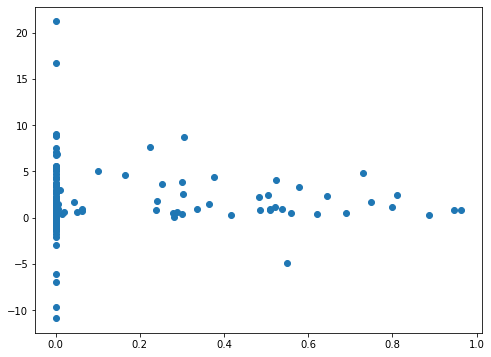

In [143]:
# plotting the relationship between Shares of managers and MB
plt.scatter(df['SHM'], df['MB'])
plt.rcParams['figure.figsize'] = 8, 6

The plot depicting M/B and managerial shareholdings provides further evidence of the absence of any observable relationship between these variables.

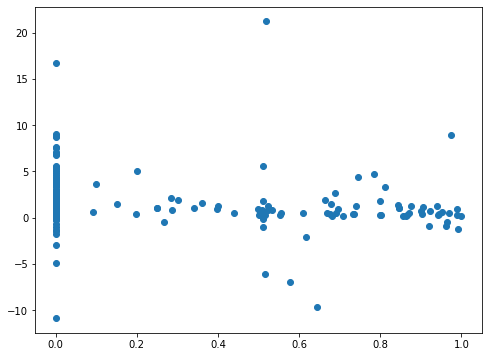

In [144]:
# plotting the relationship between Shares of State and MB
plt.scatter(df['SHST'], df['MB'])
plt.rcParams['figure.figsize'] = 8, 6

A similar conclusion applies to the relationship between M/B and state shareholdings. When state shareholdings are close to 0, M/B fluctuates in both directions.

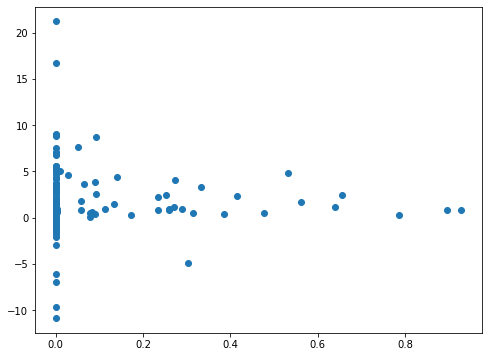

In [145]:
# plotting the relationship between Squared value of SHM and MB
plt.scatter(df['SqSHM'], df['MB'])
plt.rcParams['figure.figsize'] = 8, 6

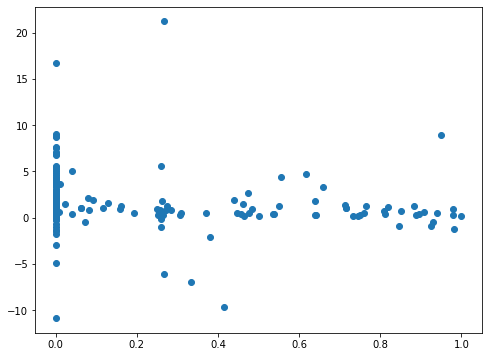

In [146]:
# plotting the relationship between Squared value of SHST and MB
plt.scatter(df['SqSHST'], df['MB'])
plt.rcParams['figure.figsize'] = 8, 6

The figures for SqSHS and SHST show no association between M/B and the squared values of managerial and state shareholdings. Besides examining the relationship between explanatory and dependent variables, it's important to explore the relationships among explanatory variables. There is a moderate negative correlation (-0.31) between state shareholdings and managerial shareholdings. This is expected because state-owned entities typically don't provide stock options or stocks to their management boards. While some state-owned companies may offer stock options, the granted amounts are negligible. However, the correlation's magnitude isn't high, allowing us to use both variables simultaneously in one model. There's also a correlation between the dummy variables, as anticipated. None of the other variables exhibits noteworthy correlations. After running a single OLS regression of M/B on managerial and state shareholdings, along with squared values of shares owned by managers and state, I test the endogeneity of management ownership using two-stage least squares regression. Long-term debt and capital expenditures relative to assets serve as instrumental (control) variables for this purpose:

In [147]:
# testing the management ownership for endogeneity
# 2SLS using debt and CAPEX to assets as instrumental variables
model = 'MB ~ 1 + SHST + SqSHM + \
        SqSHST + DummyBANKS + DummyElecUt \
        + overvalSHM + overvalSHST + [SHM ~ \
        CXP_Assets + LTD_Assets]'
Twostage = IV2SLS.from_formula(model, df).fit()

In [148]:
# printing 2SLS(1)
print(Twostage)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                     MB   R-squared:                      0.0052
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0352
No. Observations:                 206   F-statistic:                    40.600
Date:                Tue, Dec 05 2023   P-value (F-stat)                0.0000
Time:                        23:24:25   Distribution:                  chi2(8)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                              
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
Intercept       1.6126     1.1684     1.3802     0.1675     -0.6774      3.9025
DummyBANKS     -0.7601     0.6768    -1.1230    

MB = 1.61 + 12.23 ∗ SHM −1.19 ∗ SHST − 17.04 ∗ SqSHM + 0.23 ∗ SqSHST − 0.76 ∗ DummyBANKS − 0.93 ∗ DummyElecUt + 0.18 ∗ overvalSHM + 1.05 ∗ overvalSHST + 𝜀

The two-stage least squares regression produces statistically insignificant results. More precisely, all the coefficients are not statistically significant. Furthermore, all the explanatory variables are not jointly significant.

In [149]:
# 2SLS using debt and CAPEX to assets as instrumental variables with robust standard errors
Twostage2 = IV2SLS.from_formula(model, df).fit(cov_type='robust')

In [150]:
# printing 2SLS(2)
print(Twostage2)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                     MB   R-squared:                      0.0052
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0352
No. Observations:                 206   F-statistic:                    40.600
Date:                Tue, Dec 05 2023   P-value (F-stat)                0.0000
Time:                        23:24:25   Distribution:                  chi2(8)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                              
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
Intercept       1.6126     1.1684     1.3802     0.1675     -0.6774      3.9025
DummyBANKS     -0.7601     0.6768    -1.1230    

In [151]:
# The endogeneity test (Wu-Hausman)
print(Twostage.wu_hausman())

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 0.3076
P-value: 0.5798
Distributed: F(1,196)


After performing the two-stage least squares regression on M/B, I conducted an endogeneity test to determine whether the explanatory variables in the model influence managerial shareholdings. The results of the endogeneity test suggest that we cannot reject the null hypothesis, indicating that the managerial share variable is exogenous (p-values>0.05). Consequently, I proceeded to further examine the single OLS regressions. Specifically, I focused on the first OLS model since it yielded two statistically significant coefficients. To assess this model for heteroscedasticity, I created a plot of residuals against fitted values.

In [152]:
# plotting residual vs fitted values
# fitted values
model_fitted_y = ols.fittedvalues

Text(0, 0.5, 'Residuals')

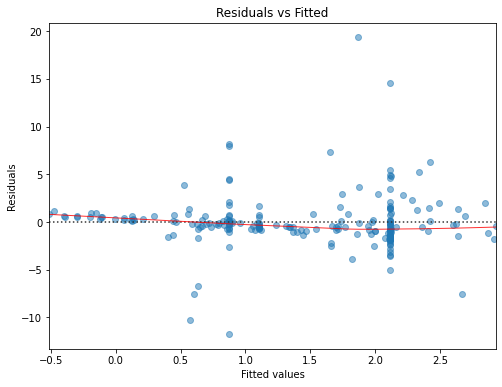

In [153]:
# plot
plot = sns.residplot(x=model_fitted_y, y='MB', data=df, lowess=True,
                     scatter_kws={'alpha': 0.5},
                     line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
# title and labels
plot.set_title('Residuals vs Fitted')
plot.set_xlabel('Fitted values')
plot.set_ylabel('Residuals')

The plot indicates that the variance of the error term is not constant, suggesting the presence of heteroscedasticity in the model. After the graphical analysis, I conducted a formal test to confirm the presence of heteroscedasticity.

In [154]:
# White's test for heteroscedasticity
white_test = het_white(ols.resid,  ols.model.exog)

In [155]:
# defining labels to use for output of White's test
labels = ['Test Statistic', 'Test Statistic p-value',
          'F-Statistic', 'F-Test p-value']

In [156]:
# printing out the results of White's test
print(dict(zip(labels, white_test)))

{'Test Statistic': 14.286726199539306, 'Test Statistic p-value': 0.8156657355441042, 'F-Statistic': 0.6893222087651875, 'F-Test p-value': 0.8338358462665632}


The White test concludes that we cannot reject the null hypothesis that the error term has a constant variance. Therefore, there is no heteroscedasticity issue in the model.
However, even if there is no heteroscedasticity, the robust standard errors transform in conventional OLS standard errors. Thus, the robust standard errors are appropriate, even under homoscedasticity. For this reason, I run a model to get a robust standard error.

In [157]:
# estimating the first model using robust errors
ols_robust = sm.OLS(dep_var, expl_var).fit(cov_type='HC3')
ols_robust.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     MB   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     5.909
Date:                Tue, 05 Dec 2023   Prob (F-statistic):           1.07e-05
Time:                        23:24:25   Log-Likelihood:                -511.18
No. Observations:                 206   AIC:                             1036.
Df Residuals:                     199   BIC:                             1060.
Df Model:                           6                                         
Covariance Type:                  HC3                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.1150      0.335      6.323      0.000       1.459       2.771
SHM            -2.3904      0.623     -3.835      0.000      -3.612      -1.169
SHST           -1.4668      0.490     -2.994      0.003      -2.427      -0.506
DummyBANKS     -1.0072      0.353     -2.855      0.004      -1.699      -0.316
DummyElecUt    -1.2385      0.579     -2.139      0.032      -2.374      -0.104
overvalSHM      3.3948      1.160      2.926      0.003       1.121       5.668
overvalSHST     0.9929      1.023      0.970      0.332      -1.013       2.999
==============================================================================
Omnibus:                      115.163   Durbin-Watson:                   2.227
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1744.237
Skew:                           1.745   Prob(JB):                         0.00
Kurtosis:                      16.822   Cond. No.                         10.9
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

The model with robust standard errors reveals six statistically significant coefficients: a constant term, managerial shareholdings, state shareholdings, a dummy variable for banks, a dummy variable for electric utilities, and an interaction variable for managerial shareholdings in overvalued companies. Additionally, all the explanatory variables jointly contribute significantly to the model.

The coefficient for state ownership implies that a one-percentage-point increase in state share is associated with a reduction in the M/B ratio by 0.0147 points, while holding other factors constant. Furthermore, a one-standard-deviation increase in state share corresponds to a 0.17 standard deviation decrease in M/B, still with other variables held constant.

Managerial shareholdings exert a more pronounced negative effect on M/B. Specifically, a one-percentage-point growth in managerial share results in a reduction of the M/B ratio by 0.0239 points, all else being equal. Similarly, a one-standard-deviation increase in managerial ownership leads to a 0.17 standard deviation decrease in M/B, again with other factors held constant.

The interaction variable indicates that the impact of managerial shareholdings on M/B is 3.39 points stronger in overvalued firms compared to undervalued ones. This suggests that increasing stocks granted to managers in overvalued firms results in a more substantial decline in M/B, keeping other factors constant. However, the sign of the coefficient for managerial shareholdings remains puzzling.

Furthermore, the presence of a dummy variable for commercial banks indicates that the M/B ratio of banks, on average, is lower by 1.01 compared to other firms.

## <center>Conclusion</center>
The outcomes of both single OLS and two-stage least squares regressions yield inconclusive results. In the M/B regression, there is evidence of a statistically significant adverse effect of both managerial and state ownership on firm performance.